## License 

Copyright 2018 Patrick Hall and the H2O.ai team

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    http://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.

# Debugging models by analyzing  residuals and loss 

#### Python imports 

In [1]:
import numpy as np                   # array, vector, matrix calculations
import os                            # file-handling
import pandas as pd                  # DataFrame handling
import shap                          # for consistent, signed variable importance measurements
import xgboost as xgb                # gradient boosting machines (GBMs)


import matplotlib.pyplot as plt      # plotting
pd.options.display.max_columns = 999 # enable display of all dataframe columns in notebook
import seaborn as sns                # plotting 

# enables display of plots in notebook
# in-notebook display
from IPython.display import Image
from IPython.display import display
%matplotlib inline

np.random.seed(12345)                # set random seed for reproducibility

## 1. Download, explore, and prepare UCI credit card default data

UCI credit card default data: https://archive.ics.uci.edu/ml/datasets/default+of+credit+card+clients

The UCI credit card default data contains demographic and payment information about credit card customers in Taiwan in the year 2005. The data set contains 23 input variables: 

* **`LIMIT_BAL`**: Amount of given credit (NT dollar)
* **`SEX`**: 1 = male; 2 = female
* **`EDUCATION`**: 1 = graduate school; 2 = university; 3 = high school; 4 = others 
* **`MARRIAGE`**: 1 = married; 2 = single; 3 = others
* **`AGE`**: Age in years 
* **`PAY_0`, `PAY_2` - `PAY_6`**: History of past payment; `PAY_0` = the repayment status in September, 2005; `PAY_2` = the repayment status in August, 2005; ...; `PAY_6` = the repayment status in April, 2005. The measurement scale for the repayment status is: -1 = pay duly; 1 = payment delay for one month; 2 = payment delay for two months; ...; 8 = payment delay for eight months; 9 = payment delay for nine months and above. 
* **`BILL_AMT1` - `BILL_AMT6`**: Amount of bill statement (NT dollar). `BILL_AMNT1` = amount of bill statement in September, 2005; `BILL_AMT2` = amount of bill statement in August, 2005; ...; `BILL_AMT6` = amount of bill statement in April, 2005. 
* **`PAY_AMT1` - `PAY_AMT6`**: Amount of previous payment (NT dollar). `PAY_AMT1` = amount paid in September, 2005; `PAY_AMT2` = amount paid in August, 2005; ...; `PAY_AMT6` = amount paid in April, 2005. 

These 23 input variables are used to predict the target variable, whether or not a customer defaulted on their credit card bill in late 2005. Because XGBoost accepts only numeric inputs, all variables will be treated as numeric.

#### Import data and clean
The credit card default data is available as an `.xls` file. Pandas reads `.xls` files automatically, so it's used to load the credit card default data and give the prediction target a shorter name: `DEFAULT_NEXT_MONTH`. 

In [2]:
# import XLS file
path = 'default_of_credit_card_clients.xls'
data = pd.read_excel(path,
                     skiprows=1) # skip the first row of the spreadsheet

# remove spaces from target column name 
data = data.rename(columns={'default payment next month': 'DEFAULT_NEXT_MONTH'}) 

#### Assign modeling roles

The shorthand name `y` is assigned to the prediction target. `X` is assigned to all other input variables in the credit card default data except the row indentifier, `ID`.

In [3]:
# assign target and inputs for GBM
y = 'DEFAULT_NEXT_MONTH'
X = [name for name in data.columns if name not in [y, 'ID']]
print('y =', y)
print('X =', X)

y = DEFAULT_NEXT_MONTH
X = ['LIMIT_BAL', 'SEX', 'EDUCATION', 'MARRIAGE', 'AGE', 'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6', 'BILL_AMT1', 'BILL_AMT2', 'BILL_AMT3', 'BILL_AMT4', 'BILL_AMT5', 'BILL_AMT6', 'PAY_AMT1', 'PAY_AMT2', 'PAY_AMT3', 'PAY_AMT4', 'PAY_AMT5', 'PAY_AMT6']


#### Display descriptive statistics
The Pandas `describe()` function displays a brief description of the credit card default data. The input variables `SEX`, `EDUCATION`, `MARRIAGE`, `PAY_0`-`PAY_6`, and the prediction target `DEFAULT_NEXT_MONTH`, are really categorical variables, but they have already been encoded into meaningful numeric, integer values, which is great for XGBoost. Also, there are no missing values in this dataset.

In [4]:
data[X + [y]].describe() # display descriptive statistics for all columns

,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH
count,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.000000,30000.000000,30000.000000,30000.000000,3.000000e+04,30000.00000,30000.000000,30000.000000,30000.000000,30000.000000
mean,167484.322667,1.603733,1.853133,1.551867,35.485500,-0.016700,-0.133767,-0.166200,-0.220667,-0.266200,-0.291100,51223.330900,49179.075167,4.701315e+04,43262.948967,40311.400967,38871.760400,5663.580500,5.921163e+03,5225.68150,4826.076867,4799.387633,5215.502567,0.221200
std,129747.661567,0.489129,0.790349,0.521970,9.217904,1.123802,1.197186,1.196868,1.169139,1.133187,1.149988,73635.860576,71173.768783,6.934939e+04,64332.856134,60797.155770,59554.107537,16563.280354,2.304087e+04,17606.96147,15666.159744,15278.305679,17777.465775,0.415062
min,10000.000000,1.000000,0.000000,0.000000,21.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-2.000000,-165580.000000,-69777.000000,-1.572640e+05,-170000.000000,-81334.000000,-339603.000000,0.000000,0.000000e+00,0.00000,0.000000,0.000000,0.000000,0.000000
25%,50000.000000,1.000000,1.000000,1.000000,28.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,-1.000000,3558.750000,2984.750000,2.666250e+03,2326.750000,1763.000000,1256.000000,1000.000000,8.330000e+02,390.00000,296.000000,252.500000,117.750000,0.000000
50%,140000.000000,2.000000,2.000000,2.000000,34.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,22381.500000,21200.000000,2.008850e+04,19052.000000,18104.500000,17071.000000,2100.000000,2.009000e+03,1800.00000,1500.000000,1500.000000,1500.000000,0.000000
75%,240000.000000,2.000000,2.000000,2.000000,41.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,67091.000000,64006.250000,6.016475e+04,54506.000000,50190.500000,49198.250000,5006.000000,5.000000e+03,4505.00000,4013.250000,4031.500000,4000.000000,0.000000
max,1000000.000000,2.000000,6.000000,3.000000,79.000000,8.000000,8.000000,8.000000,8.000000,8.000000,8.000000,964511.000000,983931.000000,1.664089e+06,891586.000000,927171.000000,961664.000000,873552.000000,1.684259e+06,896040.00000,621000.000000,426529.000000,528666.000000,1.000000


## 2. Investigate pair-wise Pearson correlations for DEFAULT_NEXT_MONTH

Monotonic relationships are much easier to explain to colleagues, bosses, customers, and regulators than more complex, non-monotonic relationships and monotonic relationships may also prevent overfitting and excess error due to variance for new data.

To train a transparent monotonic classifier, contraints must be supplied to XGBoost that determine whether the learned relationship between an input variable and the prediction target `DEFAULT_NEXT_MONTH` will be increasing for increases in an input variable or decreasing for increases in an input variable. Pearson correlation provides a linear measure of the direction of the relationship between each input variable and the target. If the pair-wise Pearson correlation between an input and `DEFAULT_NEXT_MONTH` is positive, it will be constrained to have an increasing relationship with the predictions for `DEFAULT_NEXT_MONTH`. If the pair-wise Pearson correlation is negative, the input will be constrained to have a decreasing relationship with the predictions for `DEFAULT_NEXT_MONTH`. 

Constrainsts are supplied to XGBoost in the form of a Python tuple with length equal to the number of inputs. Each item in the tuple is associated with an input variable based on its index in the tuple. The first constraint in the tuple is associated with the first variable in the training data, the second constraint in the tuple is associated with the second variable in the training data, and so on. The constraints themselves take the form of a 1 for a positive relationship and a -1 for a negative relationship.

#### Calculate Pearson correlation

The Pandas `.corr()` function returns the pair-wise Pearson correlation between variables in a Pandas DataFrame. Because `DEFAULT_NEXT_MONTH` is the last column in the `data` DataFrame, the last column of the Pearson correlation matrix indicates the direction of the linear relationship between each input variable and the prediction target, `DEFAULT_NEXT_MONTH`. According to the calculated values, as a customer's balance limit (`LIMIT_BAL`), bill amounts (`BILL_AMT1`-`BILL_AMT6`), and payment amounts (`PAY_AMT1`-`PAY_AMT6`) increase, their probability of default tends to decrease. However as a customer's number of late payments increase (`PAY_0`, `PAY_2`-`PAY6`), their probability of default usually increases. In general, the Pearson correlation values make sense, and they will be used to ensure that the modeled relationships will make sense as well. (Pearson correlation values between the target variable, DEFAULT_NEXT_MONTH, and each input variable are displayed directly below.)

In [5]:
# displays last column of Pearson correlation matrix as Pandas DataFrame
pd.DataFrame(data[X + [y]].corr()[y]).iloc[:-1] 

,DEFAULT_NEXT_MONTH
LIMIT_BAL,-0.153520
SEX,-0.039961
EDUCATION,0.028006
MARRIAGE,-0.024339
AGE,0.013890
PAY_0,0.324794
PAY_2,0.263551
PAY_3,0.235253
PAY_4,0.216614
PAY_5,0.204149


#### Create tuple of monotonicity constraints from Pearson correlation values

The last column of the Pearson correlation matrix is transformed from a numeric column in a Pandas DataFrame into a Python tuple of `1`s and `-1`s that will be used to specifiy monotonicity constraints for each input variable in XGBoost. If the Pearson correlation between an input variable and `DEFAULT_NEXT_MONTH` is positive, a positive montonic relationship constraint is specified for that variable using `1`. If the correlation is negative, a negative monotonic constraint is specified using `-1`. (Specifying `0` indicates that no constraints should be used.) The resulting tuple will be passed to XGBoost when the GBM model is trained.

In [6]:
# creates a tuple in which positive correlation values are assigned a 1
# and negative correlation values are assigned a -1
mono_constraints = tuple([int(i) for i in np.sign(data[X + [y]].corr()[y].values[:-1])])

# (-1, -1, 1, -1, 1, 1, 1, 1, 1, 1, 1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1, -1)

## 3. Train XGBoost with monotonicity constraints

XGBoost is a very accurate, open source GBM library for regression and classification tasks. XGBoost can learn complex relationships between input variables and a target variable, but here the `monotone_constraints` tuning parameter is used to enforce monotonicity between inputs and the prediction for `DEFAULT_NEXT_MONTH`. XGBoost's early stopping functionality is also used to limit overfitting to the training data

XGBoost is available from: https://github.com/dmlc/xgboost and the implementation of XGBoost is described in detail here: http://www.kdd.org/kdd2016/papers/files/rfp0697-chenAemb.pdf.

After training, GBM variable importance is calculated and displayed. GBM variable importance is a global measure of the overall impact of an input variable on the GBM model predictions. Global variable importance values give an indication of the magnitude of a variable's contribution to model predictions for all observations. To enhance trust in the GBM model, variable importance values should typically conform to human domain knowledge and reasonable expectations.

#### Split data into training and test sets for early stopping

The credit card default data is split into training and test sets to monitor and prevent overtraining. Reproducibility is another important factor in creating trustworthy models, and randomly splitting datasets can introduce randomness in model predictions and other results. A random seed is used here to ensure the data split is reproducible.

In [7]:
np.random.seed(12345) # set random seed for reproducibility
split_ratio = 0.7     # 70%/30% train/test split

# execute split
split = np.random.rand(len(data)) < split_ratio
train = data[split]
test = data[~split]

# summarize split
print('Train data rows = %d, columns = %d' % (train.shape[0], train.shape[1]))
print('Test data rows = %d, columns = %d' % (test.shape[0], test.shape[1]))

Train data rows = 20946, columns = 25
Test data rows = 9054, columns = 25


#### Train XGBoost GBM classifier
To train an XGBoost classifier, the training and test data must be converted from Pandas DataFrames into SVMLight format. The `DMatrix()` function in the XGBoost package is used to convert the data. Many XGBoost tuning parameters must be specified as well. Typically a grid search would be performed to identify the best parameters for a given modeling task. For brevity's sake, a previously-discovered set of good tuning parameters are specified here. Notice that the monotonicity constraints are passed to XGBoost using the `monotone_constraints` parameter. Because gradient boosting methods typically resample training data, an additional random seed is also specified for XGBoost using the `seed` paramter to create reproducible predictions, error rates, and variable importance values. To avoid overfitting, the `early_stopping_rounds` parameter is used to stop the training process after the test area under the curve (AUC) statistic fails to increase for 50 iterations.

In [47]:
# XGBoost uses SVMLight data structure, not Numpy arrays or Pandas DataFrames 
dtrain = xgb.DMatrix(train[X], train[y])
dtest = xgb.DMatrix(test[X], test[y])

# used to calibrate predictions to mean of y 
base_y = train[y].mean()

# tuning parameters
params = {
    'objective': 'binary:logistic',             # produces 0-1 probabilities for binary classification
    'booster': 'gbtree',                        # base learner will be decision tree
    'eval_metric': 'logloss',                   # stop training based on
    'eta': 0.08,                                # learning rate
    'subsample': 0.9,                           # use 90% of rows in each decision tree
    'colsample_bytree': 0.9,                    # use 90% of columns in each decision tree
    'max_depth': 15,                            # allow decision trees to grow to depth of 15
    'monotone_constraints':mono_constraints,    # 1 = increasing relationship, -1 = decreasing relationship
    'base_score': base_y,                       # calibrate predictions to mean of y 
    'seed': 12345                               # set random seed for reproducibility
}

# watchlist is used for early stopping
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# train model
xgb_model = xgb.train(params,                   # set tuning parameters from above                   
                      dtrain,                   # training data
                      1000,                     # maximum of 1000 iterations (trees)
                      evals=watchlist,          # use watchlist for early stopping 
                      early_stopping_rounds=50, # stop after 50 iterations (trees) without increase in AUC
                      verbose_eval=True)        # display iteration progress


[0]	train-logloss:0.517487	eval-logloss:0.51404
Multiple eval metrics have been passed: 'eval-logloss' will be used for early stopping.

Will train until eval-logloss hasn't improved in 50 rounds.
[1]	train-logloss:0.504097	eval-logloss:0.500144
[2]	train-logloss:0.49331	eval-logloss:0.489053
[3]	train-logloss:0.48449	eval-logloss:0.480157
[4]	train-logloss:0.476882	eval-logloss:0.472429
[5]	train-logloss:0.470593	eval-logloss:0.46606
[6]	train-logloss:0.465221	eval-logloss:0.460639
[7]	train-logloss:0.460893	eval-logloss:0.456227
[8]	train-logloss:0.456987	eval-logloss:0.452346
[9]	train-logloss:0.453662	eval-logloss:0.449056
[10]	train-logloss:0.450854	eval-logloss:0.446329
[11]	train-logloss:0.448211	eval-logloss:0.443774
[12]	train-logloss:0.445944	eval-logloss:0.441601
[13]	train-logloss:0.444034	eval-logloss:0.439837
[14]	train-logloss:0.442334	eval-logloss:0.438174
[15]	train-logloss:0.440674	eval-logloss:0.436801
[16]	train-logloss:0.439326	eval-logloss:0.435491
[17]	train-logl

In [58]:
test_yhat = test.copy(deep=True)
test_yhat.reset_index(drop=True, inplace=True)

yhat = 'p_DEFAULT_NEXT_MONTH'
test_yhat[yhat] = pd.DataFrame(xgb_model.predict(xgb.DMatrix(test[X]), ntree_limit=xgb_model.best_ntree_limit)) 
#test_yhat['s'] = 1
#test_yhat.loc[test_yhat['DEFAULT_NEXT_MONTH'] == 0, 's'] = -1
#test_yhat['r_DEFAULT_NEXT_MONTH'] = test_yhat['s'] * np.sqrt(-2*(test_yhat[y]*np.log(test_yhat[yhat]) +
#                                                                 ((1 - test_yhat[y])*np.log(1 - test_yhat[yhat]))))
#test_yhat = test_yhat.drop('s', axis=1)

test_yhat['r_DEFAULT_NEXT_MONTH'] = -test_yhat[y]*np.log(test_yhat['p_DEFAULT_NEXT_MONTH']) -\
                                     (1 - test_yhat[y])*np.log(1 - test_yhat['p_DEFAULT_NEXT_MONTH'])

In [59]:
test_yhat['r_DEFAULT_NEXT_MONTH'].mean()

0.42615648818482926

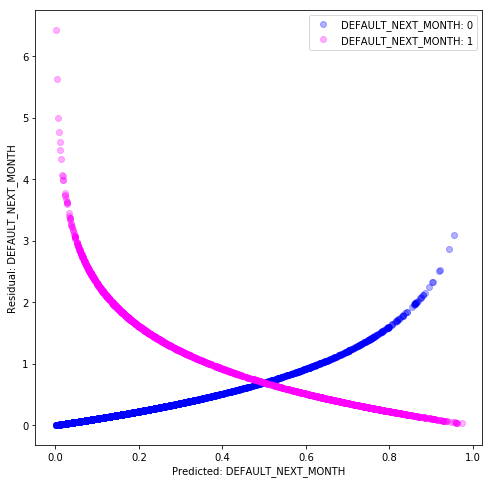

In [37]:
groups = test_yhat.groupby('DEFAULT_NEXT_MONTH') # define groups
fig, ax_ = plt.subplots(figsize=(8, 8))          # initialize figure

plt.xlabel('Predicted: DEFAULT_NEXT_MONTH')
plt.ylabel('Residual: DEFAULT_NEXT_MONTH')

# plot groups with appropriate color
color_list = ['blue', 'magenta'] 
c_idx = 0
for name, group in groups:
    ax_.plot(group.p_DEFAULT_NEXT_MONTH, group.r_DEFAULT_NEXT_MONTH, label=' '.join(['DEFAULT_NEXT_MONTH:', str(name)]),
             marker='o', linestyle='', color=color_list[c_idx], alpha=0.3)
    c_idx += 1

_ = ax_.legend(loc=1) # legend

In [38]:
test_yhat_sorted = test_yhat.sort_values(by='r_DEFAULT_NEXT_MONTH', ascending=False).reset_index(drop=True)
test_yhat_sorted

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
0,983,500000,1,1,2,36,-2,-2,-2,-2,-2,-2,45106,81264,18122,27229,21462,27911,81690,18225,27365,21570,28050,17397,1,0.001612,6.430410
1,25772,350000,2,1,1,33,0,-1,-1,-1,-1,-1,82964,68532,17926,17966,30741,31088,68940,18018,18058,30897,31244,88461,1,0.003612,5.623448
2,11571,200000,1,2,2,30,-2,-2,-2,-2,-2,-2,48492,49934,24753,123439,132269,129224,20294,24891,125171,17816,26269,4349,1,0.006771,4.995058
3,2561,310000,2,1,2,32,-2,-2,-2,-2,-2,-2,20138,8267,65993,8543,1695,750,8267,66008,8543,1695,750,7350,1,0.008443,4.774378
4,10650,400000,2,1,2,27,-2,-2,-2,-2,-2,-2,5457,4438,5048,7013,52189,16153,4460,5072,7048,52317,16232,4516,1,0.010024,4.602728
5,16209,360000,2,1,1,35,-2,-1,0,-1,-1,-1,94657,34529,106276,73331,7759,31840,45000,100000,73427,7759,31840,12577,1,0.011311,4.481949
6,4957,280000,1,1,2,33,-1,-1,0,0,0,0,8814,151643,153190,147589,149291,151357,151650,5546,6007,5507,6007,4184,1,0.013150,4.331344
7,7125,140000,2,2,2,24,-2,-2,-2,-2,-2,-2,137037,127771,124714,73593,73344,78629,5053,3615,2573,2858,8000,2000,1,0.016980,4.075700
8,2250,550000,2,2,1,32,0,0,0,0,0,0,546741,535509,548020,530672,155083,165975,22863,167622,14000,4300,158064,28840,1,0.017501,4.045489
9,14554,450000,1,2,2,30,0,0,0,0,0,0,610723,555086,497132,514249,462666,472480,20200,18000,25135,432130,17000,20000,1,0.018431,3.993735


In [12]:
if os.path.isfile('shap_error_values.csv'):
    
    shap_values = np.loadtxt('shap_error_values.csv', delimiter=',') # load
    print('Pre-calculated Shapley values loaded from disk.')   # print confirmation
          
else: 
    
    xgb_model.set_attr(objective='binary:logistic')
    explainer = shap.TreeExplainer(xgb_model, test[X], feature_dependence='independent', model_output='logloss')
    shap_values = explainer.shap_values(test[X], y=test[y])         # long step (hours!)
    np.savetxt('shap_error_values.csv', shap_values, delimiter=',') # save
    

Pre-calculated Shapley values loaded from disk.


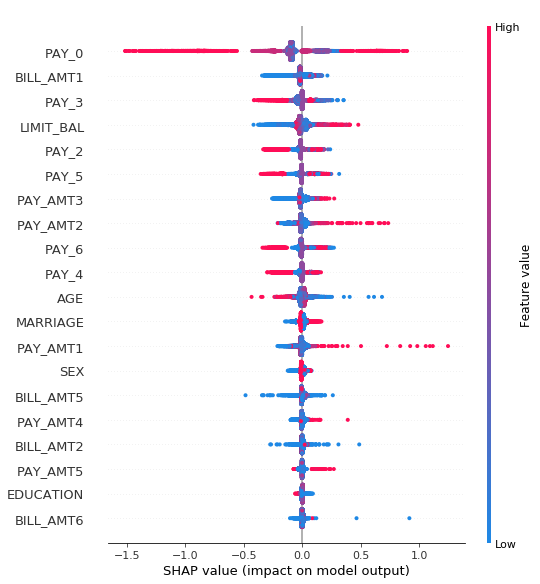

In [13]:
# plot Shapley variable importance summary 
shap.summary_plot(shap_values[:, :-1], test[xgb_model.feature_names])

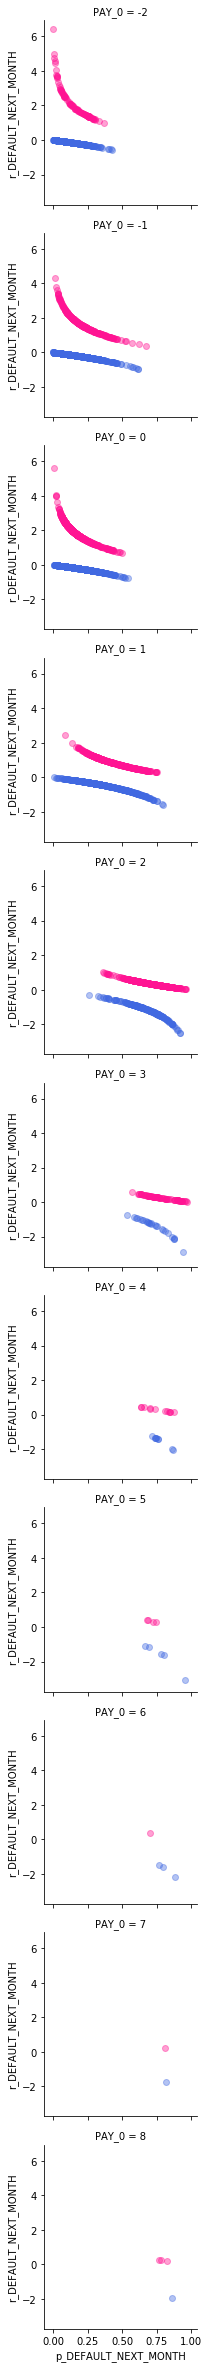

In [14]:
# use Seaborn FacetGrid for convenience
g = sns.FacetGrid(test_yhat, row='PAY_0', hue=y, palette={1: 'deeppink', 0: 'royalblue'})
_ = g.map(plt.scatter, 'p_DEFAULT_NEXT_MONTH', 'r_DEFAULT_NEXT_MONTH', alpha=0.4)

In [15]:
def mean_resid(xs, y, frame, model, abs_=False, resolution=20, bins=None):
    
    """ 
    
    Args:
        xs: Variable for which to calculate partial dependence.
        frame: Pandas DataFrame for which to calculate partial dependence.
        model: XGBoost model for which to calculate partial dependence.
        abs_:
        resolution: The number of points across the domain of xs for which 
                    to calculate partial dependence, default 20.
        bins: List of values at which to set xs, default 20 equally-spaced 
              points between column minimum and maximum.
    
    Returns:
        
        
    """
    
    # turn off pesky Pandas copy warning
    pd.options.mode.chained_assignment = None
    
    # initialize empty Pandas DataFrame with correct column names
    resid_frame = pd.DataFrame(columns=[xs,'residual'])
    
    # cache original column values 
    col_cache = frame.loc[:, xs].copy(deep=True)
  
    # determine values at which to calculate partial dependence
    if bins == None:
        min_ = frame[xs].min()
        max_ = frame[xs].max()
        by = (max_ - min_)/resolution
        bins = np.arange(min_, max_, by)
        
    # calculate partial dependence  
    # by setting column of interest to constant 
    # and scoring the altered data and taking the mean of the predictions
    for j in bins:
        
        rframe_ = pd.DataFrame(columns=['actual', 'pred', 'sign', 'res'])
        
        frame.loc[:, xs] = j
        dframe = xgb.DMatrix(frame.drop(y, axis=1))
        
        rframe_['actual'] = frame[y].reset_index(drop=True)
        rframe_['pred'] = pd.DataFrame(model.predict(dframe)) 
        rframe_['sign'] = 1
        rframe_.loc[rframe_['actual'] == 0, 'sign'] = -1
        rframe_['res'] = rframe_['sign'] * np.sqrt(-2*(rframe_['actual']*np.log(rframe_['pred']) +
                                                   ((1 - rframe_['actual'])*np.log(1 - rframe_['pred']))))

        if abs_:
            resid_j = np.abs(rframe_['res']).mean()
        else:
            resid_j = rframe_['res'].mean()
        
        #rframe_.plot(kind='scatter', x='pred', y='res')
        del rframe_            
        
        resid_frame = resid_frame.append({xs:j,
                                          'residual': resid_j}, 
                                          ignore_index=True)
        
    # return input frame to original cached state    
    frame.loc[:, xs] = col_cache

    return resid_frame


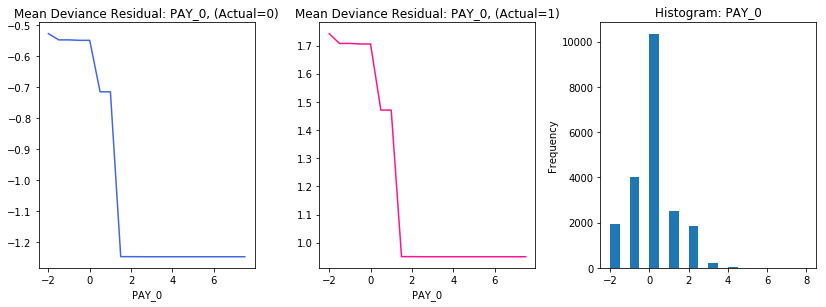

In [16]:
resid_PAY_0_0 = mean_resid('PAY_0', y, test.loc[test[y] == 0, X + [y]], xgb_model)          
resid_PAY_0_1 = mean_resid('PAY_0', y, test.loc[test[y] == 1, X + [y]], xgb_model)     

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=False)
plt.tight_layout()
plt.subplots_adjust(left=0.0, right=1.8, wspace=0.3)
_ = resid_PAY_0_0.plot(kind='line', x='PAY_0', y='residual', title='Mean Deviance Residual: PAY_0, (Actual=0)',
                       ax=ax0, legend=False, color='royalblue')
_ = resid_PAY_0_1.plot(kind='line', x='PAY_0', y='residual', title='Mean Deviance Residual: PAY_0, (Actual=1)',
                       ax=ax1, legend=False, color='deeppink')
_ = train['PAY_0'].plot(kind='hist', bins=20, title='Histogram: PAY_0', ax=ax2)

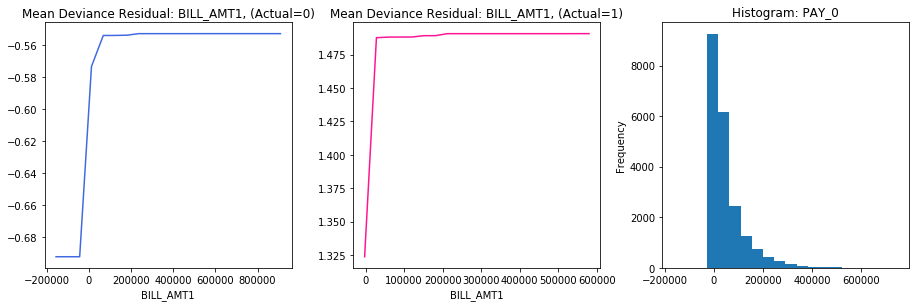

In [17]:
resid_BILL_AMT1_0 = mean_resid('BILL_AMT1', y, test.loc[test[y] == 0, X + [y]], xgb_model)          
resid_BILL_AMT1_1 = mean_resid('BILL_AMT1', y, test.loc[test[y] == 1, X + [y]], xgb_model)     

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=False)
plt.tight_layout()
plt.subplots_adjust(left=0.0, right=2, wspace=0.25)
_ = resid_BILL_AMT1_0.plot(kind='line', x='BILL_AMT1', y='residual', title='Mean Deviance Residual: BILL_AMT1, (Actual=0)',
                       ax=ax0, legend=False, color='royalblue')
_ = resid_BILL_AMT1_1.plot(kind='line', x='BILL_AMT1', y='residual', title='Mean Deviance Residual: BILL_AMT1, (Actual=1)',
                       ax=ax1, legend=False, color='deeppink')
_ = train['BILL_AMT1'].plot(kind='hist', bins=20, title='Histogram: PAY_0', ax=ax2)

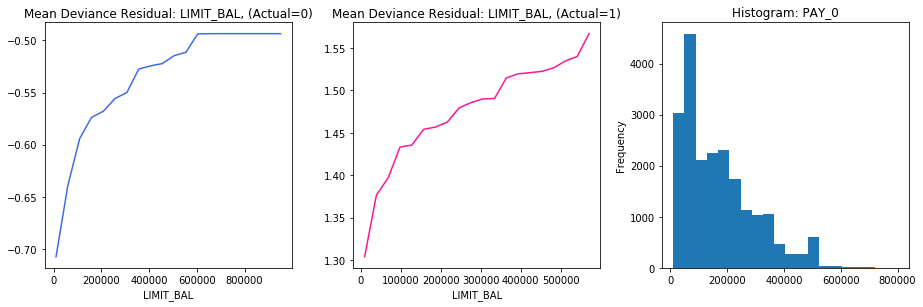

In [18]:
resid_LIMIT_BAL_0 = mean_resid('LIMIT_BAL', y, test.loc[test[y] == 0, X + [y]], xgb_model)          
resid_LIMIT_BAL_1 = mean_resid('LIMIT_BAL', y, test.loc[test[y] == 1, X + [y]], xgb_model)     

fig, (ax0, ax1, ax2) = plt.subplots(ncols=3, sharey=False)
plt.tight_layout()
plt.subplots_adjust(left=0.0, right=2, wspace=0.25)
_ = resid_LIMIT_BAL_0.plot(kind='line', x='LIMIT_BAL', y='residual', title='Mean Deviance Residual: LIMIT_BAL, (Actual=0)',
                       ax=ax0, legend=False, color='royalblue')
_ = resid_LIMIT_BAL_1.plot(kind='line', x='LIMIT_BAL', y='residual', title='Mean Deviance Residual: LIMIT_BAL, (Actual=1)',
                       ax=ax1, legend=False, color='deeppink')
_ = train['LIMIT_BAL'].plot(kind='hist', bins=20, title='Histogram: PAY_0', ax=ax2)

In [19]:
import h2o    
from h2o.estimators.random_forest import H2ORandomForestEstimator # for single tree

h2o.init()

def train_cv_surrogate_dt(model_id, X, yhat, frame):
                                          
    # initialize single tree surrogate model
    surrogate = H2ORandomForestEstimator(ntrees=1,          # use only one tree
                                         sample_rate=1,     # use all rows in that tree
                                         mtries=-2,         # use all columns in that tree
                                         max_depth=4,       # shallow trees are easier to understand
                                         seed=12345,        # random seed for reproducibility
                                         nfolds=3,
                                         model_id=model_id) # gives MOJO artifact a recognizable name

    # train single tree surrogate model
    surrogate.train(x=X, y=yhat, training_frame=h2o.H2OFrame(frame))

    # persist MOJO (compiled, representation of trained model)
    # from which to generate plot of surrogate
    mojo_path = surrogate.download_mojo(path='.')
    print('Generated MOJO path:\n', mojo_path)
    
    return mojo_path, surrogate
    
mojo_path0, surrogate0 = train_cv_surrogate_dt('surrogate0', X, 'r_DEFAULT_NEXT_MONTH', test_yhat[test_yhat[y] == 0])                                     
mojo_path1, surrogate1 = train_cv_surrogate_dt('surrogate1', X, 'r_DEFAULT_NEXT_MONTH', test_yhat[test_yhat[y] == 1])  

h2o.cluster().shutdown()

Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "1.8.0_191"; Java(TM) SE Runtime Environment (build 1.8.0_191-b12); Java HotSpot(TM) 64-Bit Server VM (build 25.191-b12, mixed mode)
  Starting server from /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmpvlfbyy8w
  JVM stdout: /tmp/tmpvlfbyy8w/h2o_patrickh_started_from_python.out
  JVM stderr: /tmp/tmpvlfbyy8w/h2o_patrickh_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321... successful.


H2O cluster uptime:,00 secs
H2O cluster timezone:,America/New_York
H2O data parsing timezone:,UTC
H2O cluster version:,3.20.0.4
H2O cluster version age:,4 months and 29 days !!!
H2O cluster name:,H2O_from_python_patrickh_34b2yl
H2O cluster total nodes:,1
H2O cluster free memory:,3.422 Gb
H2O cluster total cores:,8
H2O cluster allowed cores:,8
H2O cluster status:,"accepting new members, healthy"


/home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/utils/shared_utils.py:177: FutureWarning: Method .as_matrix will be removed in a future version. Use .values instead.
  data = _handle_python_lists(python_obj.as_matrix().tolist(), -1)[1]


Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /home/patrickh/workspace/interpretable_machine_learning_with_python/surrogate0.zip
Parse progress: |█████████████████████████████████████████████████████████| 100%
drf Model Build progress: |███████████████████████████████████████████████| 100%
Generated MOJO path:
 /home/patrickh/workspace/interpretable_machine_learning_with_python/surrogate1.zip
H2O session _sid_9ec0 closed.


In [20]:
surrogate0.cross_validation_metrics_summary()

Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.0657835,0.0012085,0.0635247,0.0661679,0.0676579
mean_residual_deviance,0.0103199,0.0001790,0.0100681,0.0102254,0.0106661
mse,0.0103199,0.0001790,0.0100681,0.0102254,0.0106661
r2,0.8590108,0.0044246,0.8621944,0.8502685,0.8645694
residual_deviance,0.0103199,0.0001790,0.0100681,0.0102254,0.0106661
rmse,0.1015793,0.0008783,0.1003400,0.1011208,0.103277
rmsle,0.0,NaN,NaN,NaN,NaN


In [21]:
surrogate1.cross_validation_metrics_summary()

Cross-Validation Metrics Summary: 


,mean,sd,cv_1_valid,cv_2_valid,cv_3_valid
mae,0.2123250,0.0065274,0.2011306,0.2121054,0.2237391
mean_residual_deviance,0.1219441,0.0111176,0.0997325,0.1339372,0.1321626
mse,0.1219441,0.0111176,0.0997325,0.1339372,0.1321626
r2,0.828193,0.0114960,0.8509304,0.8197796,0.8138689
residual_deviance,0.1219441,0.0111176,0.0997325,0.1339372,0.1321626
rmse,0.3484402,0.0163330,0.3158045,0.3659744,0.3635418
rmsle,0.1239519,0.0015758,0.1208303,0.1258882,0.1251373


In [22]:
from h2o.backend import H2OLocalServer                            # for plotting local tree in-notebook

import re
import subprocess

def get_gv(title, model_id, mojo_path):

    # locate h2o jar
    hs = H2OLocalServer()
    h2o_jar_path = hs._find_jar()
    print('Discovered H2O jar path:\n', h2o_jar_path)

    # construct command line call to generate graphviz version of 
    # surrogate tree see for more information: 
    # http://docs.h2o.ai/h2o/latest-stable/h2o-genmodel/javadoc/index.html
    gv_file_name = model_id + '.gv'
    gv_args = str('-cp ' + h2o_jar_path +
                  ' hex.genmodel.tools.PrintMojo --tree 0 -i '
                  + mojo_path + ' -o').split()
    gv_args.insert(0, 'java')
    gv_args.append(gv_file_name)
    if title is not None:
        gv_args = gv_args + ['--title', title]
    
    # call 
    print()
    print('Calling external process ...')
    print(' '.join(gv_args))
    _ = subprocess.call(gv_args)
    
get_gv('Residual Surrogate (Actual=0)', 'surrogate0', mojo_path0)
get_gv('Residual Surrogate (Actual=1)', 'surrogate1', mojo_path1)

Discovered H2O jar path:
 /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/workspace/interpretable_machine_learning_with_python/surrogate0.zip -o surrogate0.gv --title Residual Surrogate (Actual=0)
Discovered H2O jar path:
 /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar

Calling external process ...
java -cp /home/patrickh/anaconda3/lib/python3.6/site-packages/h2o/backend/bin/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i /home/patrickh/workspace/interpretable_machine_learning_with_python/surrogate1.zip -o surrogate1.gv --title Residual Surrogate (Actual=1)


In [23]:
def get_png(model_id):

    gv_file_name = model_id + '.gv'
    
    # construct call to generate PNG from 
    # graphviz representation of the tree
    png_file_name = model_id + '.png'
    png_args = str('dot -Tpng ' + gv_file_name + ' -o ' + png_file_name)
    png_args = png_args.split()

    # call
    print('Calling external process ...')
    print(' '.join(png_args))
    _ = subprocess.call(png_args)
    
get_png('surrogate0')
get_png('surrogate1')

Calling external process ...
dot -Tpng surrogate0.gv -o surrogate0.png
Calling external process ...
dot -Tpng surrogate1.gv -o surrogate1.png


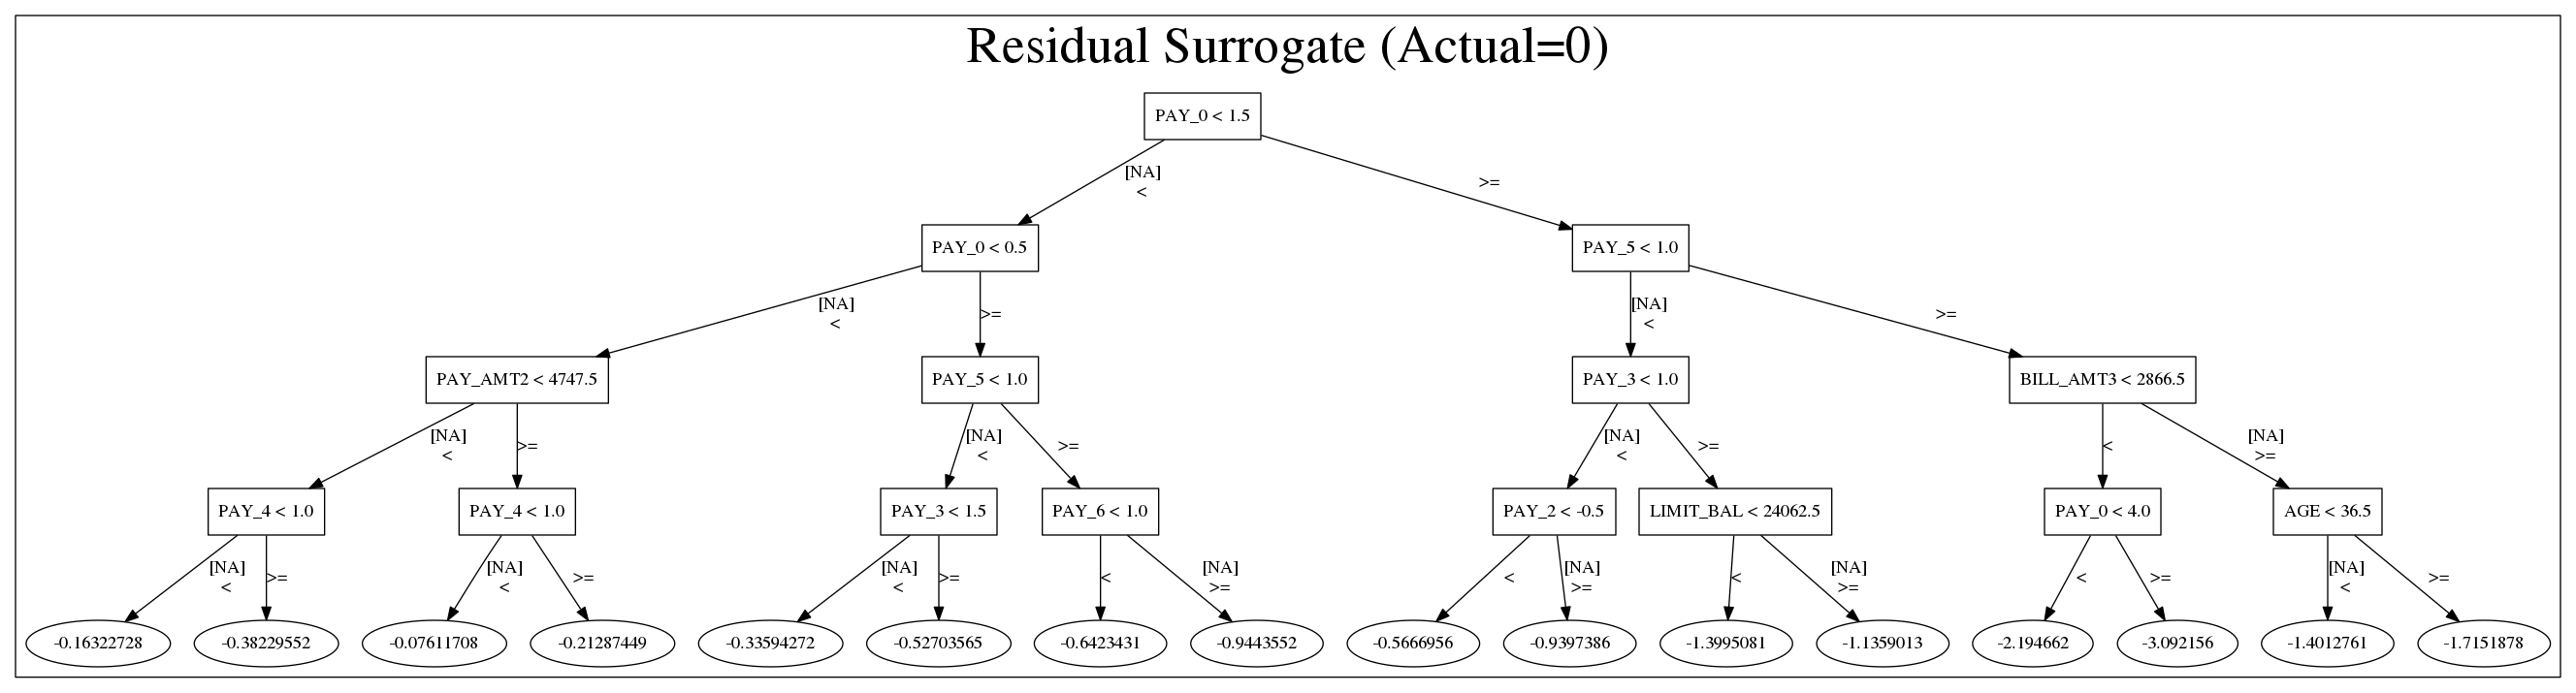

In [24]:
# display in-notebook
display(Image(('surrogate0.png')))

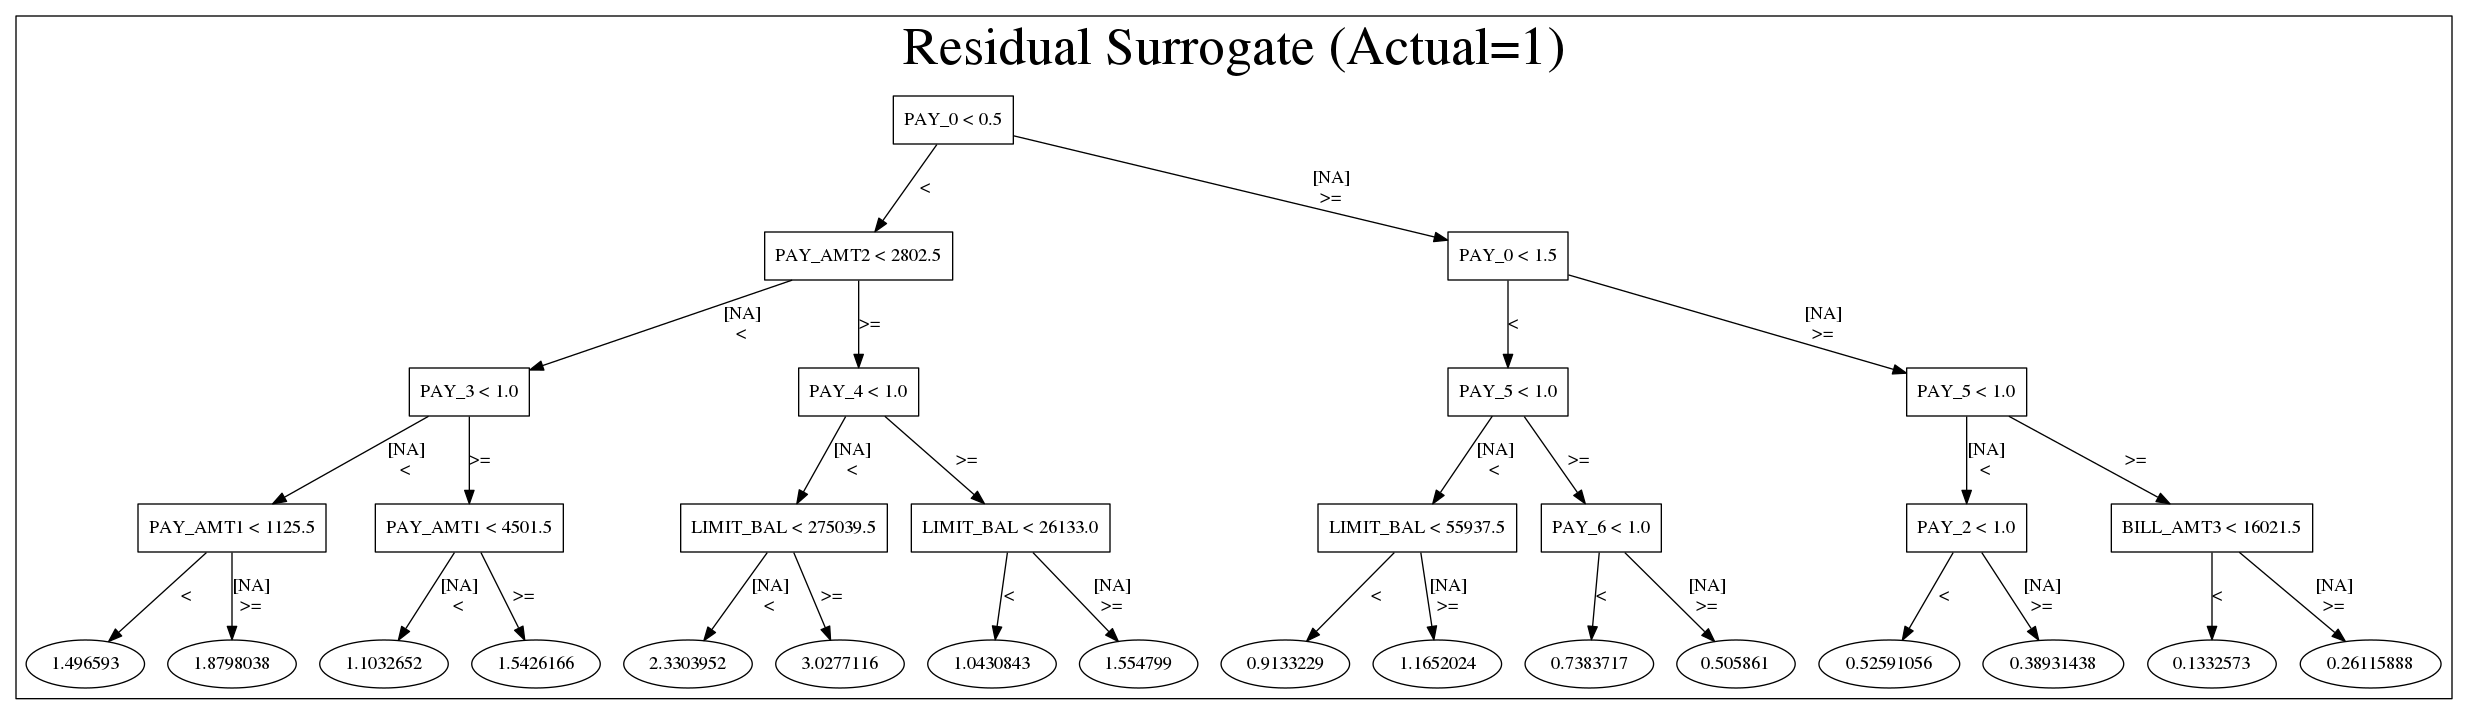

In [25]:
# display in-notebook
display(Image(('surrogate1.png')))

In [26]:
row_id = test_yhat_sorted.loc[0, 'ID']
row = test_yhat[test_yhat['ID'] == row_id]

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
300,983,500000,1,1,2,36,-2,-2,-2,-2,-2,-2,45106,81264,18122,27229,21462,27911,81690,18225,27365,21570,28050,17397,1,0.001612,6.43041


In [40]:
shap_values.shape

(9054, 23)

In [46]:
shap_values.sum(axis=1).mean()

-0.22787700946026485

In [27]:
shap_values[row.index[0], :]

array([ 0.47771501, -0.1149665 ,  0.0828161 ,  0.12028964, -0.11748154,
        0.4081815 ,  0.23793686,  0.35234798,  0.1269311 ,  0.31449539,
        0.25388374,  0.1627857 ,  0.08327773, -0.00285365,  0.0238321 ,
        0.04144803,  0.01421726,  1.11383308,  0.37821304,  0.2312607 ,
        0.08975081,  0.18198794,  0.11919415])

In [28]:
# reset test data index to find riskiest customer in shap_values 
# sort to find largest positive contributions
s_df = pd.DataFrame(shap_values[row.index[0], :].reshape(23, 1), columns=['Loss Contribs'], index=X)
s_df.sort_values(by='Loss Contribs', inplace=True, ascending=False)

In [29]:
s_df['Loss Contribs']

PAY_AMT1     1.113833
LIMIT_BAL    0.477715
PAY_0        0.408181
PAY_AMT2     0.378213
PAY_3        0.352348
PAY_5        0.314495
PAY_6        0.253884
PAY_2        0.237937
PAY_AMT3     0.231261
PAY_AMT5     0.181988
BILL_AMT1    0.162786
PAY_4        0.126931
MARRIAGE     0.120290
PAY_AMT6     0.119194
PAY_AMT4     0.089751
BILL_AMT2    0.083278
EDUCATION    0.082816
BILL_AMT5    0.041448
BILL_AMT4    0.023832
BILL_AMT6    0.014217
BILL_AMT3   -0.002854
SEX         -0.114966
AGE         -0.117482
Name: Loss Contribs, dtype: float64

In [32]:
s_df['Loss Contribs'].sum()

4.579096157555271

In [39]:
test_yhat['r_DEFAULT_NEXT_MONTH'].mean()

0.4276544172552346

#### Plot top local contributions as reason codes

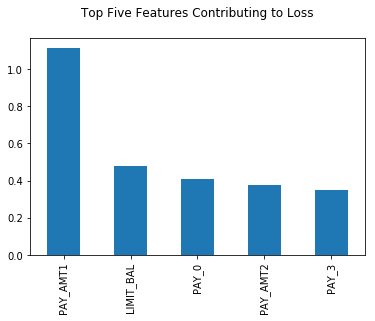

In [30]:
_ = s_df[:5].plot(kind='bar', 
                  title='Top Five Features Contributing to Loss\n', 
                  legend=False)

In [31]:
row # helps understand reason codes

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,PAY_5,PAY_6,BILL_AMT1,BILL_AMT2,BILL_AMT3,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,DEFAULT_NEXT_MONTH,p_DEFAULT_NEXT_MONTH,r_DEFAULT_NEXT_MONTH
300,983,500000,1,1,2,36,-2,-2,-2,-2,-2,-2,45106,81264,18122,27229,21462,27911,81690,18225,27365,21570,28050,17397,1,0.001612,6.43041
